In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

import pickle

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

In [3]:

df = pd.concat(
    [
        pd.read_csv('./customer_churn_dataset-training-master.csv'), 
        pd.read_csv('./customer_churn_dataset-testing-master.csv')
    ], 
    axis=0)
df.reset_index(drop=True, inplace=True)
df


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
505202,64370.0,45.0,Female,33.0,12.0,6.0,21.0,Basic,Quarterly,947.0,14.0,1.0
505203,64371.0,37.0,Male,6.0,1.0,5.0,22.0,Standard,Annual,923.0,9.0,1.0
505204,64372.0,25.0,Male,39.0,14.0,8.0,30.0,Premium,Monthly,327.0,20.0,1.0
505205,64373.0,50.0,Female,18.0,19.0,7.0,22.0,Standard,Monthly,540.0,13.0,1.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505207 entries, 0 to 505206
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         505206 non-null  float64
 1   Age                505206 non-null  float64
 2   Gender             505206 non-null  object 
 3   Tenure             505206 non-null  float64
 4   Usage Frequency    505206 non-null  float64
 5   Support Calls      505206 non-null  float64
 6   Payment Delay      505206 non-null  float64
 7   Subscription Type  505206 non-null  object 
 8   Contract Length    505206 non-null  object 
 9   Total Spend        505206 non-null  float64
 10  Last Interaction   505206 non-null  float64
 11  Churn              505206 non-null  float64
dtypes: float64(9), object(3)
memory usage: 46.3+ MB


# Preprocessing

In [4]:
df.drop(columns='CustomerID', inplace=True) 

df.columns = [col.lower().replace(' ', '_') for col in df.columns] 

In [10]:
df.shape

(505207, 11)

In [5]:
df.dropna(inplace=True)

In [12]:
df.shape

(505206, 11)

In [13]:
descrete_col = ['age', 'tenure', 'usage_frequency', 'support_calls', 'payment_delay', 'last_interaction', 'churn']
for col in descrete_col:
    df[col] = df[col].astype(int)
df

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
0,30,Female,39,14,5,18,Standard,Annual,932.0,17,1
1,65,Female,49,1,10,8,Basic,Monthly,557.0,6,1
2,55,Female,14,4,6,18,Basic,Quarterly,185.0,3,1
3,58,Male,38,21,7,7,Standard,Monthly,396.0,29,1
4,23,Male,32,20,5,8,Basic,Monthly,617.0,20,1
...,...,...,...,...,...,...,...,...,...,...,...
505202,45,Female,33,12,6,21,Basic,Quarterly,947.0,14,1
505203,37,Male,6,1,5,22,Standard,Annual,923.0,9,1
505204,25,Male,39,14,8,30,Premium,Monthly,327.0,20,1
505205,50,Female,18,19,7,22,Standard,Monthly,540.0,13,1


# Univarient Analysis

In [14]:

def make_histogram(df, target_feature, bins = 10, custom_ticks=None, unit='', additional=''):
    plt.figure(figsize=(10, 5))
    plt.hist(df[target_feature], bins=bins)
    if custom_ticks is not None:
        plt.xticks(custom_ticks)
    plt.ylabel('Count')
    plt.xlabel(target_feature)
    plt.title(f"Distribution of {target_feature.lower()}{additional}:\n")
    plt.grid()
    plt.show()
    print(f"Distribution of {target_feature.lower()}{additional}: {df[target_feature].mean():.2f} ± {df[target_feature].median():.2f} {unit}\nMedian: {df[target_feature].median():.2f} {unit}\nMinimum: {df[target_feature].min()} {unit}\nMaximum: {df[target_feature].max()} {unit}\n{df[target_feature].skew():.3f} Skewness\n")

def make_piechart(df, target_feature, additional=''):
    dict_of_val_counts = dict(df[target_feature].value_counts())
    data = list(dict_of_val_counts.values())
    keys = list(dict_of_val_counts.keys())
    
    palette_color = sns.color_palette('bright')
    plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
    plt.title(f"Distribution of Cutomer's {target_feature}:")
    plt.show()
    print_str = f"Distribution of cutomer's {target_feature.lower()}{additional}:"
    for k, v in zip(keys, data):
        print_str += f"\n{v} {k}"
    print(print_str)

def make_barplot(df, target_feature, custom_ticks=None, unit='', additional=''):
    plt.figure(figsize=(10, 5))
    dict_of_val_counts = dict(df[target_feature].value_counts())
    data = list(dict_of_val_counts.values())
    keys = list(dict_of_val_counts.keys())
    plt.bar(keys, data)
    if custom_ticks is not None:
        plt.xticks(custom_ticks)
    plt.xlabel(f'{target_feature.capitalize()}{additional}')
    plt.ylabel('Frequency')
    plt.title(f"Distribution of cutomer's {target_feature.lower()}{additional}\n")
    plt.grid(axis='y')
    plt.show()
    print(f"Distribution of cutomer's {target_feature.lower()}{additional}: {df[target_feature].mean():.2f} ± {df[target_feature].median():.2f} {unit}\nMedian: {df[target_feature].median():.2f} {unit}\nMinimum: {df[target_feature].min()} {unit}\nMaximum: {df[target_feature].max()} {unit}\n\n{df[target_feature].skew():.3f} Skewness\n")
    
def make_boxplot(df, feature):
    plt.figure(figsize=(10,5))
    sns.boxplot(df, x=feature)
    plt.title(f"Boxplot of {feature}\n")
    plt.xlabel(feature)
    plt.ylabel("Values")
    plt.show()

## Categorical features

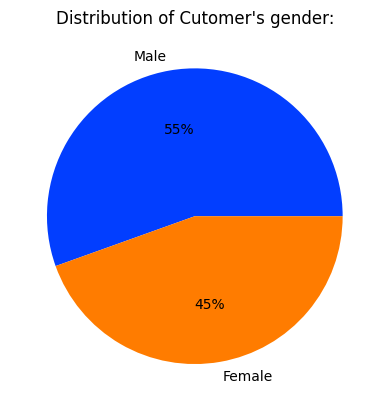

Distribution of cutomer's gender:
280273 Male
224933 Female


In [15]:
make_piechart(df, 'gender')

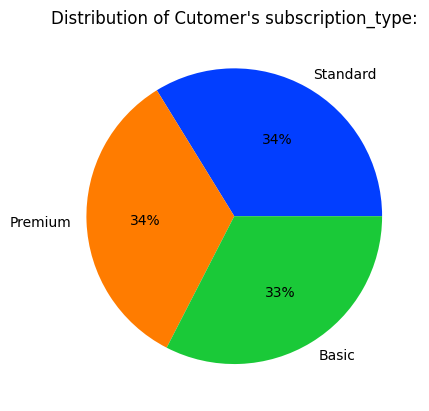

Distribution of cutomer's subscription_type:
170630 Standard
170099 Premium
164477 Basic


In [16]:
make_piechart(df, 'subscription_type')

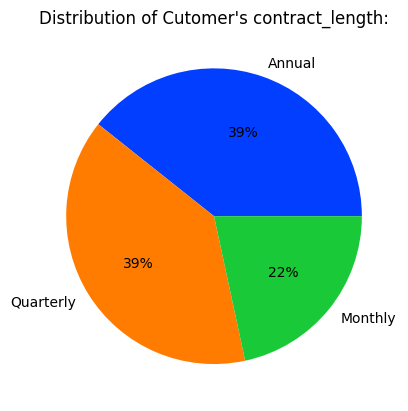

Distribution of cutomer's contract_length:
198608 Annual
197364 Quarterly
109234 Monthly


In [17]:
make_piechart(df, 'contract_length')

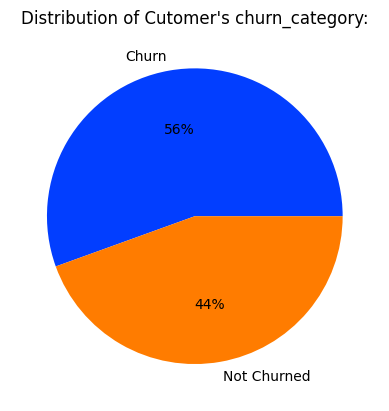

Distribution of cutomer's churn_category:
280492 Churn
224714 Not Churned


In [18]:
filtered = df.copy()
filtered['churn_category'] = ['Churn' if x == 1.0 else 'Not Churned' for x in df['churn']]
make_piechart(filtered, 'churn_category')

# Descrete Data

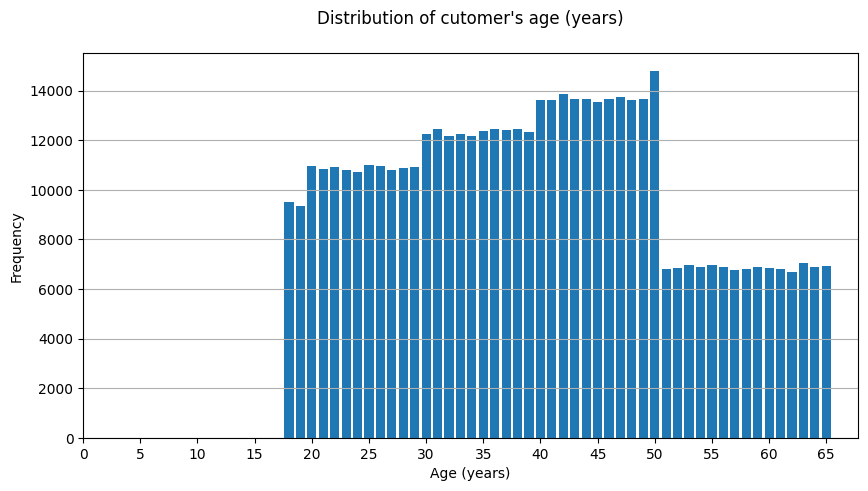

Distribution of cutomer's age (years): 39.70 ± 40.00 years
Median: 40.00 years
Minimum: 18 years
Maximum: 65 years

0.144 Skewness



In [19]:
make_barplot(df, 'age', custom_ticks=np.arange(0, 66, 5), additional=' (years)', unit='years')

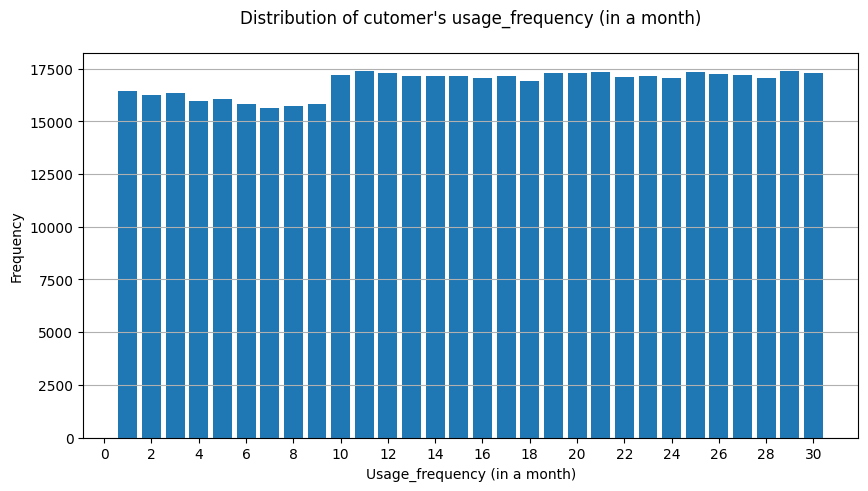

Distribution of cutomer's usage_frequency (in a month): 15.71 ± 16.00 times
Median: 16.00 times
Minimum: 1 times
Maximum: 30 times

-0.034 Skewness



In [20]:
make_barplot(df, 'usage_frequency', custom_ticks=np.arange(0, 31, 2), unit='times', additional=' (in a month)')

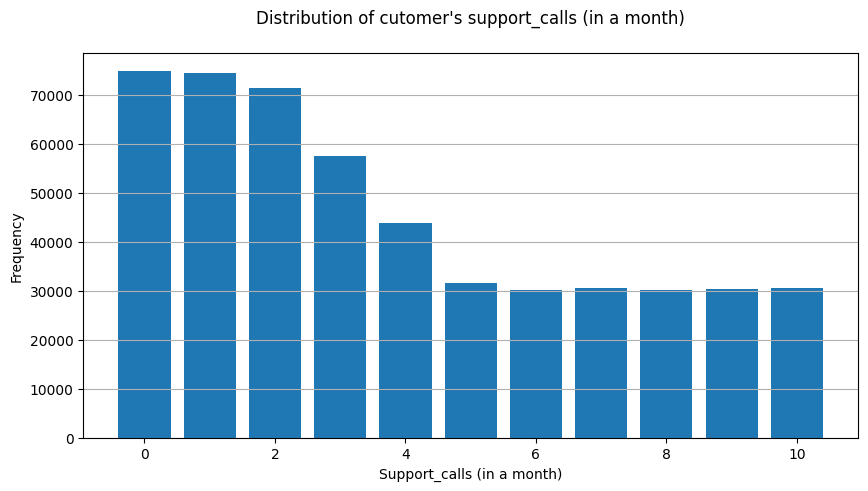

Distribution of cutomer's support_calls (in a month): 3.83 ± 3.00 calls
Median: 3.00 calls
Minimum: 0 calls
Maximum: 10 calls

0.544 Skewness



In [21]:
make_barplot(df, 'support_calls', unit='calls', additional=' (in a month)')

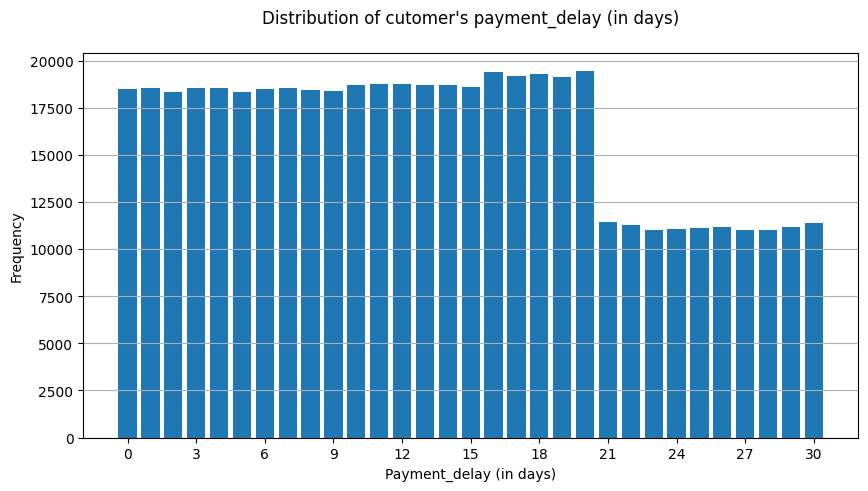

Distribution of cutomer's payment_delay (in days): 13.50 ± 13.00 days
Median: 13.00 days
Minimum: 0 days
Maximum: 30 days

0.200 Skewness



In [22]:
make_barplot(df, 'payment_delay', custom_ticks=np.arange(0, 32, 3), unit='days', additional=' (in days)')

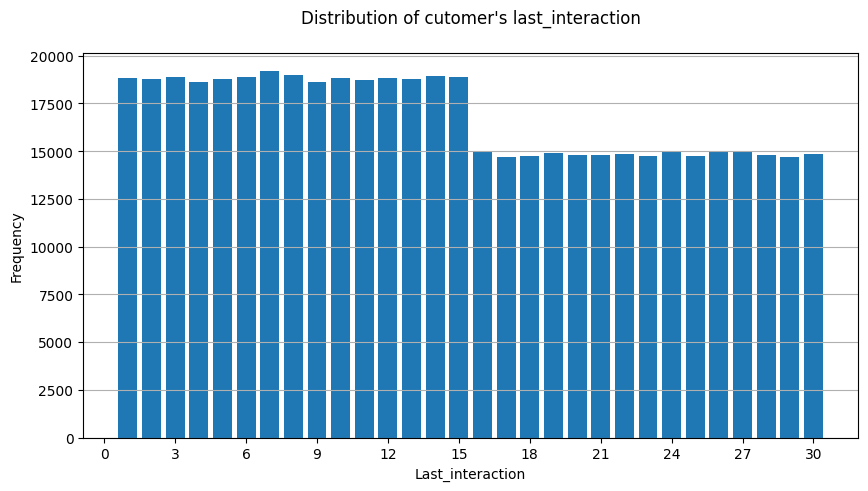

Distribution of cutomer's last_interaction: 14.61 ± 14.00 days
Median: 14.00 days
Minimum: 1 days
Maximum: 30 days

0.155 Skewness



In [23]:
make_barplot(df, 'last_interaction', custom_ticks=np.arange(0, 32, 3), unit='days', additional='')

## Continuous Data

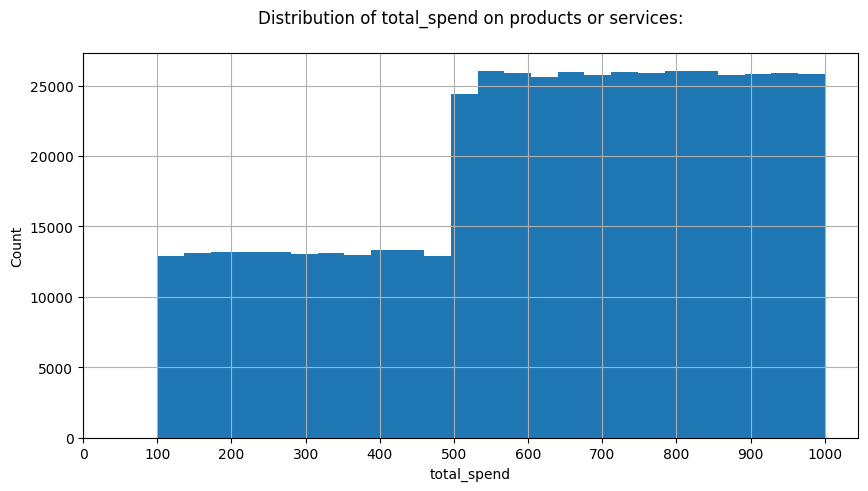

Distribution of total_spend on products or services: 620.07 ± 648.90 USD
Median: 648.90 USD
Minimum: 100.0 USD
Maximum: 1000.0 USD
-0.395 Skewness



In [24]:
make_histogram(df, 'total_spend', bins=25, custom_ticks=np.arange(0, 1001, 100), unit='USD', additional=" on products or services")

# Multivariate Analysis

## Do gender and churn rate have any relationship?

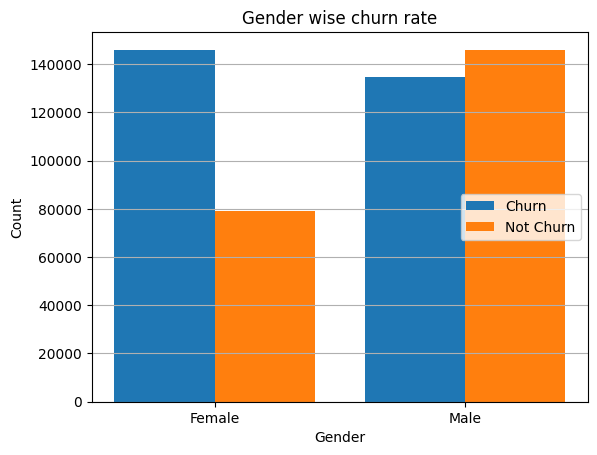

In [25]:
gender_churn = df.groupby(['gender', 'churn']).size().unstack()

X = list(gender_churn.index)
churn_0 = list(gender_churn.iloc[:, 0])
churn_1 = list(gender_churn.iloc[:, 1])
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Churn')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Not Churn')
  
plt.xticks(X_axis, X)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title("Gender wise churn rate")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

## Are there any noticeable trends in payment delays among customers who churned?

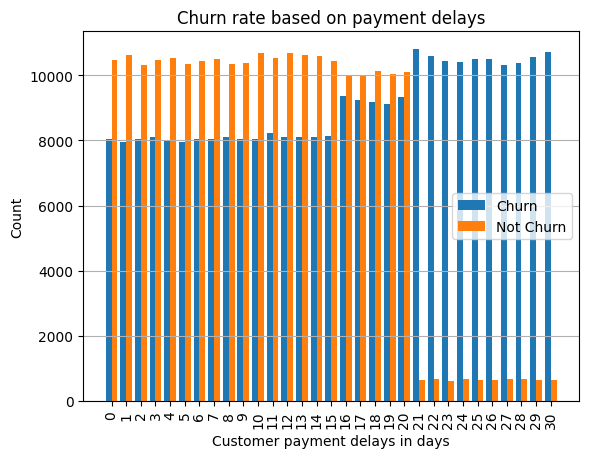

In [26]:
filtered = df.groupby(['payment_delay', 'churn']).size().unstack()

X = list(filtered.index)
churn_0 = list(filtered.iloc[:, 0])
churn_1 = list(filtered.iloc[:, 1])
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Churn')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Not Churn')
  
plt.xticks(X_axis, X, rotation=90)
plt.xlabel("Customer payment delays in days")
plt.ylabel('Count')
plt.title("Churn rate based on payment delays")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

## What is the distribution of usage frequency for churned vs. non-churned customers?

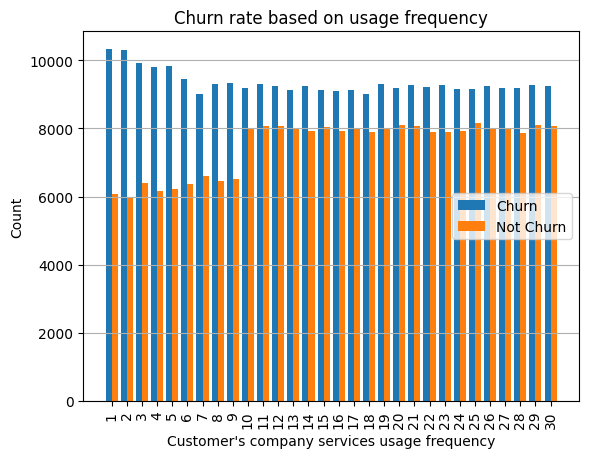

In [27]:
filtered = df.groupby(['usage_frequency', 'churn']).size().unstack()

X = list(filtered.index)
churn_0 = list(filtered.iloc[:, 0])
churn_1 = list(filtered.iloc[:, 1])
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Churn')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Not Churn')
  
plt.xticks(X_axis, X, rotation=90)
plt.xlabel("Customer's company services usage frequency")
plt.ylabel('Count')
plt.title("Churn rate based on usage frequency")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

## Are customers with longer tenures less likely to churn?

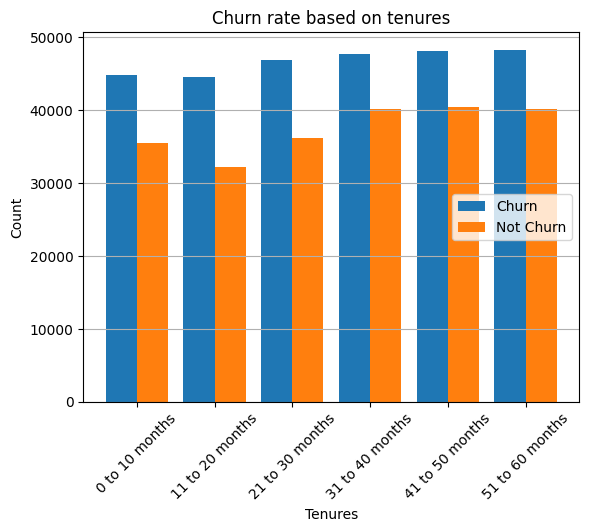

In [28]:
def categorize_age(age):
    if 0 <= age <= 10:
        return '0 to 10 months'
    elif 11 <= age <= 20:
        return '11 to 20 months'
    elif 21 <= age <= 30:
        return '21 to 30 months'
    elif 31 <= age <= 40:
        return '31 to 40 months'
    elif 41 <= age <= 50:
        return '41 to 50 months'
    elif 51 <= age <= 60:
        return '51 to 60 months'
    else:
        pass 

filtered = df.copy()
filtered['tenure_segmentation'] = df['tenure'].apply(categorize_age)
filtered = filtered.groupby(['tenure_segmentation', 'churn']).size().unstack()

X = list(filtered.index)
churn_0 = list(filtered.iloc[:, 0])
churn_1 = list(filtered.iloc[:, 1])
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Churn')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Not Churn')
  
plt.xticks(X_axis, X, rotation=45)
plt.xlabel('Tenures')
plt.ylabel('Count')
plt.title("Churn rate based on tenures")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

## Do customers with more support calls tend to churn more?

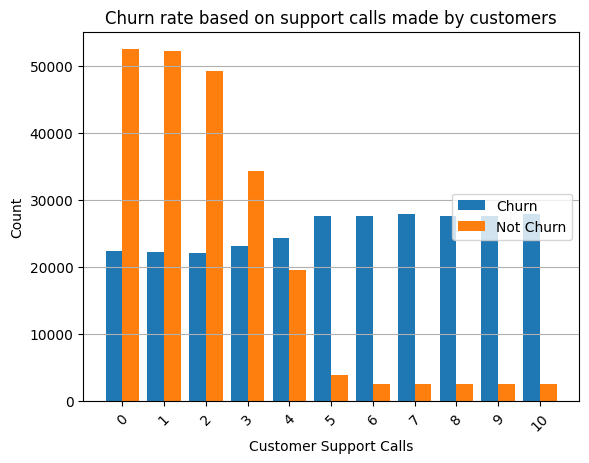

In [29]:
filtered = df.groupby(['support_calls', 'churn']).size().unstack()

X = list(filtered.index)
churn_0 = list(filtered.iloc[:, 0])
churn_1 = list(filtered.iloc[:, 1])
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Churn')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Not Churn')
  
plt.xticks(X_axis, X, rotation=45)
plt.xlabel('Customer Support Calls')
plt.ylabel('Count')
plt.title("Churn rate based on support calls made by customers")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

## Does the subscription type influence the churn rate?

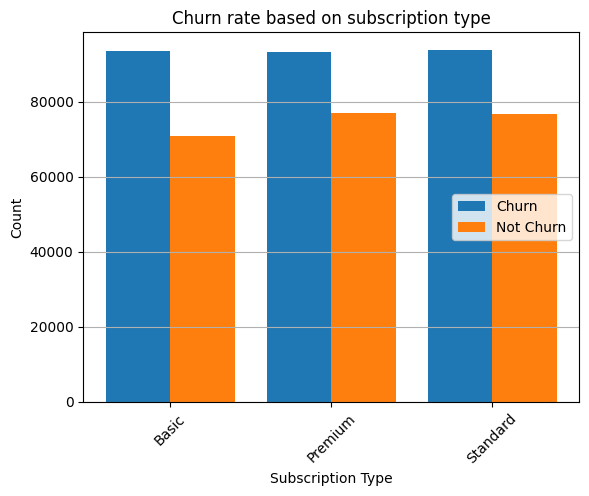

In [30]:
filtered = df.groupby(['subscription_type', 'churn']).size().unstack()

X = list(filtered.index)
churn_0 = list(filtered.iloc[:, 0])
churn_1 = list(filtered.iloc[:, 1])
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Churn')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Not Churn')
  
plt.xticks(X_axis, X, rotation=45)
plt.xlabel('Subscription Type')
plt.ylabel('Count')
plt.title("Churn rate based on subscription type")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

## Is there a pattern in contract length for customers who churned?

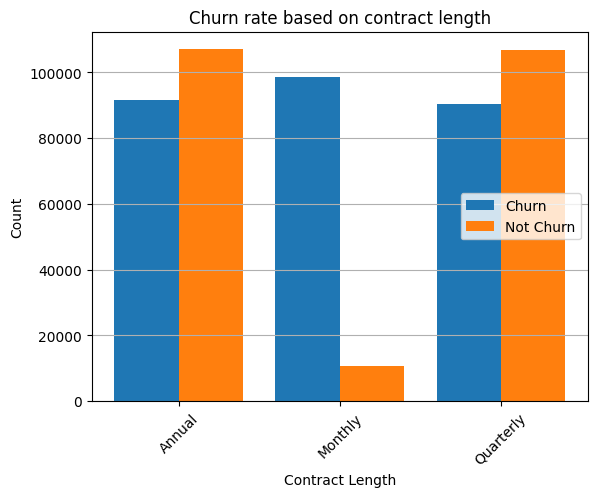

In [31]:
filtered = df.groupby(['contract_length', 'churn']).size().unstack()

X = list(filtered.index)
churn_0 = list(filtered.iloc[:, 0])
churn_1 = list(filtered.iloc[:, 1])
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Churn')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Not Churn')
  
plt.xticks(X_axis, X, rotation=45)
plt.xlabel('Contract Length')
plt.ylabel('Count')
plt.title("Churn rate based on contract length")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

# Train-Test Split

In [7]:
y = df['churn']
X = df.drop(columns='churn')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [9]:
X_train

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction
0,19.0,Female,48.0,7.0,3.0,30.0,Premium,Annual,787.00,29.0
1,65.0,Female,11.0,20.0,9.0,14.0,Standard,Monthly,562.00,13.0
2,38.0,Male,8.0,20.0,1.0,4.0,Basic,Quarterly,961.86,8.0
3,38.0,Female,59.0,25.0,10.0,4.0,Premium,Annual,706.00,14.0
4,46.0,Male,38.0,24.0,10.0,16.0,Standard,Annual,260.00,25.0
...,...,...,...,...,...,...,...,...,...,...
404159,24.0,Female,1.0,4.0,2.0,18.0,Standard,Quarterly,740.72,15.0
404160,62.0,Male,29.0,23.0,9.0,24.0,Standard,Quarterly,327.10,11.0
404161,34.0,Male,13.0,16.0,1.0,6.0,Premium,Quarterly,520.36,23.0
404162,35.0,Male,23.0,18.0,4.0,10.0,Standard,Monthly,420.00,3.0


In [35]:
X_test

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction
0,58,Male,2,20,6,24,Standard,Quarterly,664.00,20
1,52,Male,14,13,2,13,Standard,Monthly,650.00,9
2,46,Male,38,3,0,9,Basic,Annual,571.47,24
3,29,Female,59,27,5,22,Basic,Quarterly,502.00,2
4,42,Male,29,7,1,20,Basic,Annual,541.34,10
...,...,...,...,...,...,...,...,...,...,...
101037,29,Male,33,9,1,1,Basic,Annual,801.41,29
101038,34,Male,43,28,9,11,Standard,Annual,435.00,30
101039,50,Female,40,13,0,1,Premium,Quarterly,651.28,9
101040,49,Female,46,6,0,20,Standard,Quarterly,897.68,2


# One Hot Encoding

In [10]:
encoder = OneHotEncoder(sparse_output=False)

encoder.fit(X_train[['gender', 'subscription_type', 'contract_length']])
feature_names = encoder.get_feature_names_out(['gender', 'subscription_type', 'contract_length'])
feature_names
train_categorical_one_encoded_data = encoder.transform(X_train[['gender', 'subscription_type', 'contract_length']])
train_OHE_df = pd.DataFrame(train_categorical_one_encoded_data, columns=feature_names)

test_categorical_one_encoded_data = encoder.transform(X_test[['gender', 'subscription_type', 'contract_length']])
test_OHE_df = pd.DataFrame(test_categorical_one_encoded_data, columns=feature_names)

In [37]:
train_OHE_df.head(3)

,gender_Female,gender_Male,subscription_type_Basic,subscription_type_Premium,subscription_type_Standard,contract_length_Annual,contract_length_Monthly,contract_length_Quarterly
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [38]:
test_OHE_df.head(3)

,gender_Female,gender_Male,subscription_type_Basic,subscription_type_Premium,subscription_type_Standard,contract_length_Annual,contract_length_Monthly,contract_length_Quarterly
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [11]:
X_train = X_train.drop(columns=['gender', 'subscription_type', 'contract_length'])
X_test = X_test.drop(columns=['gender', 'subscription_type', 'contract_length'])

In [12]:
X_train.head(3)

,age,tenure,usage_frequency,support_calls,payment_delay,total_spend,last_interaction
0,19.0,48.0,7.0,3.0,30.0,787.00,29.0
1,65.0,11.0,20.0,9.0,14.0,562.00,13.0
2,38.0,8.0,20.0,1.0,4.0,961.86,8.0


In [41]:
X_test.head(3)

,age,tenure,usage_frequency,support_calls,payment_delay,total_spend,last_interaction
0,58,2,20,6,24,664.00,20
1,52,14,13,2,13,650.00,9
2,46,38,3,0,9,571.47,24


In [13]:
X_train = pd.concat([X_train, train_OHE_df], axis=1)
X_test = pd.concat([X_test, test_OHE_df], axis=1)

In [43]:
X_train.head(3)

,age,tenure,usage_frequency,support_calls,payment_delay,total_spend,last_interaction,gender_Female,gender_Male,subscription_type_Basic,subscription_type_Premium,subscription_type_Standard,contract_length_Annual,contract_length_Monthly,contract_length_Quarterly
0,19,48,7,3,30,787.00,29,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,65,11,20,9,14,562.00,13,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,38,8,20,1,4,961.86,8,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [44]:
X_test.head(3)

,age,tenure,usage_frequency,support_calls,payment_delay,total_spend,last_interaction,gender_Female,gender_Male,subscription_type_Basic,subscription_type_Premium,subscription_type_Standard,contract_length_Annual,contract_length_Monthly,contract_length_Quarterly
0,58,2,20,6,24,664.00,20,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,52,14,13,2,13,650.00,9,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,46,38,3,0,9,571.47,24,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [14]:
with open('encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

In [15]:

with open('encoder.pkl', 'rb') as file:
    loaded_encoder = pickle.load(file)
    
loaded_encoder.transform([['Male', 'Premium', 'Monthly']])

c:\Users\91827\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


array([[0., 1., 0., 1., 0., 0., 1., 0.]])

# PCA

         Feature_1  Feature_2  Target
0      -166.666719 -16.831219       1
1        58.457548  20.683890       0
2      -341.575218  23.661122       0
3       -85.736400 -27.466815       1
4       360.378519  -6.762457       1
...            ...        ...     ...
404159 -120.403395  30.069073       0
404160  293.360318   2.462884       1
404161   99.932907  18.172059       0
404162  200.272137   8.057019       1
404163   84.511737 -26.872018       0

[404164 rows x 3 columns]


c:\Users\91827\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


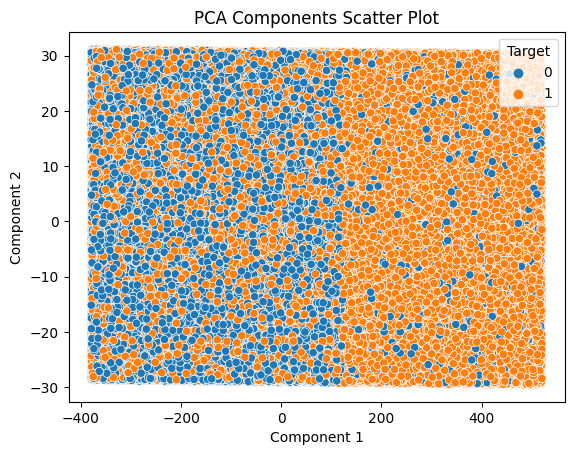

In [58]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
pca.explained_variance_ratio_
data = {
    'Feature_1': X_pca[:, 0],
    'Feature_2': X_pca[:, 1],
    'Target': y_train
}

pca_df = pd.DataFrame(data)
print(pca_df)
sns.scatterplot(data=pca_df, x='Feature_1', y='Feature_2', hue='Target')

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA Components Scatter Plot')

plt.legend(title='Target')
plt.show()

In [56]:
def print_evaluation_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print()
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    print()
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # class_report = classification_report(y_true, y_pred)
    # print("Classification Report:")
    # print(class_report)

# Models Training

In [49]:
decision_tree_classifier = DecisionTreeClassifier(random_state=42)
decision_tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [50]:
random_forest_classifier = RandomForestClassifier(random_state=42)
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [51]:
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [52]:
logistic_classifier = LogisticRegression(random_state=42, max_iter=1000)
logistic_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

# Validating Models

Accuracy: 0.85
Precision: 0.87
Recall: 0.85

Confusion Matrix:
[[37887  6872]
 [ 8622 47661]]



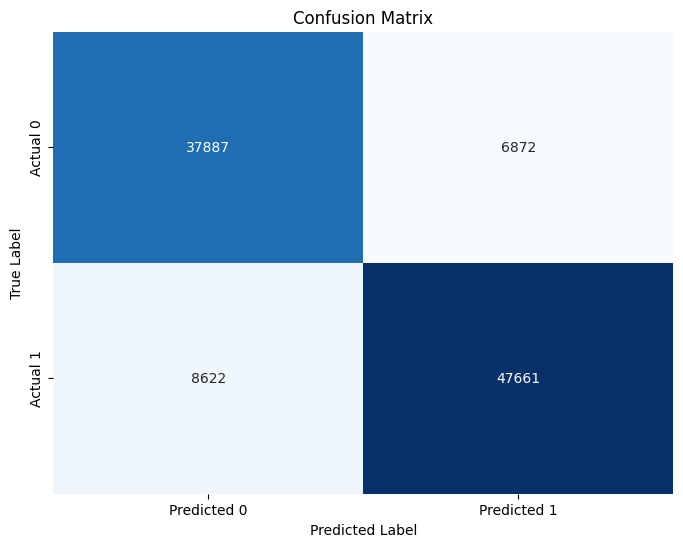

Accuracy: 0.88
Precision: 0.90
Recall: 0.89

Confusion Matrix:
[[39468  5291]
 [ 6452 49831]]



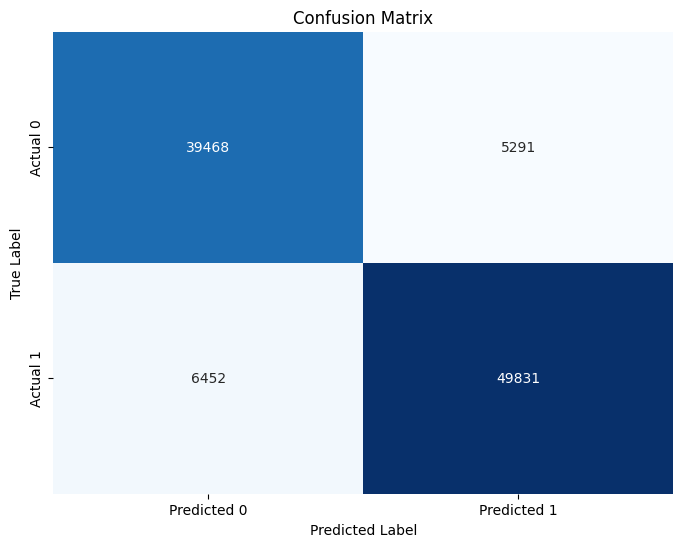

Accuracy: 0.94
Precision: 0.90
Recall: 1.00

Confusion Matrix:
[[38372  6387]
 [  170 56113]]



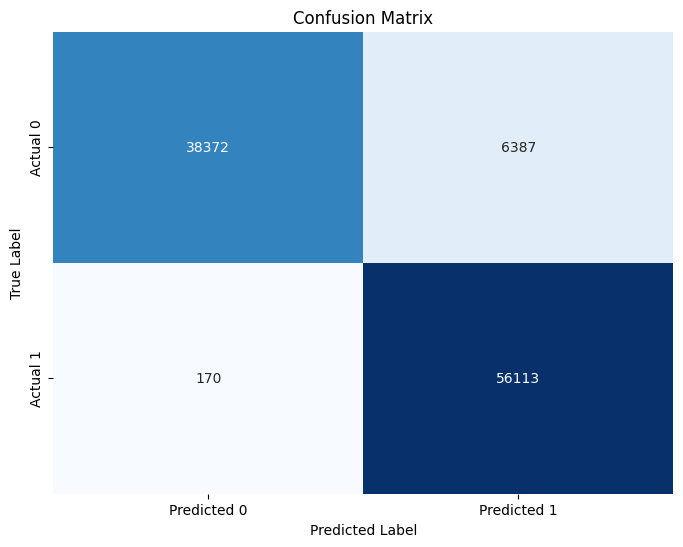

Accuracy: 0.93
Precision: 0.90
Recall: 0.99

Confusion Matrix:
[[38400  6359]
 [  389 55894]]



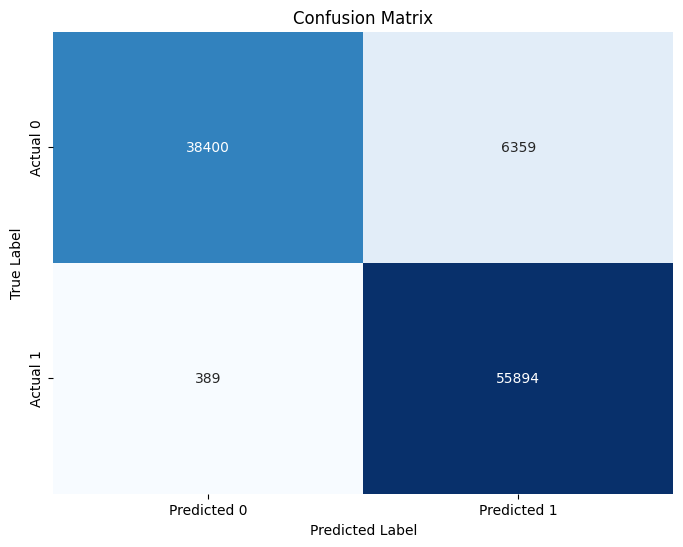

In [57]:


y_pred = logistic_classifier.predict(X_test)

print_evaluation_metrics(y_test, y_pred)



Accuracy: 0.88
Precision: 0.90
Recall: 0.89

Confusion Matrix:
[[39468  5291]
 [ 6452 49831]]



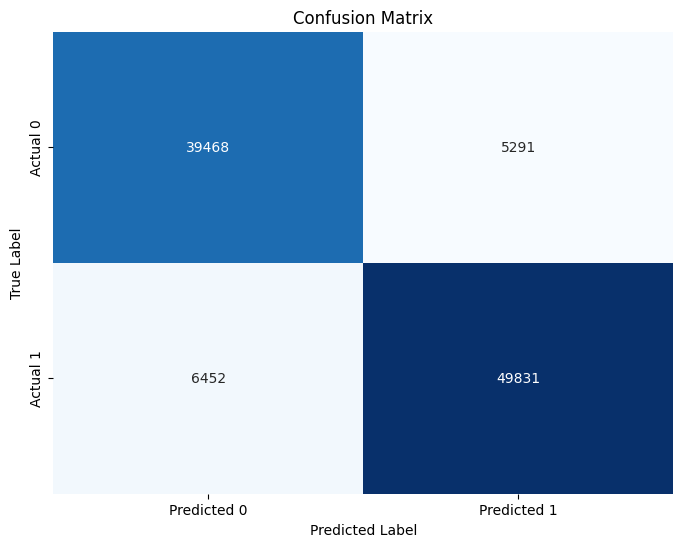

In [60]:


y_pred = decision_tree_classifier.predict(X_test)
print_evaluation_metrics(y_test, y_pred)



Accuracy: 0.94
Precision: 0.90
Recall: 1.00

Confusion Matrix:
[[38372  6387]
 [  170 56113]]



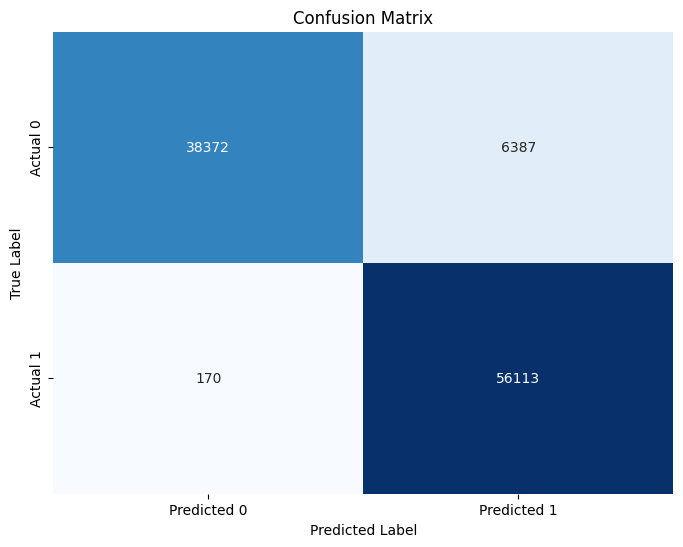

In [61]:

y_pred = random_forest_classifier.predict(X_test)
print_evaluation_metrics(y_test, y_pred)

Accuracy: 0.93
Precision: 0.90
Recall: 0.99

Confusion Matrix:
[[38400  6359]
 [  389 55894]]



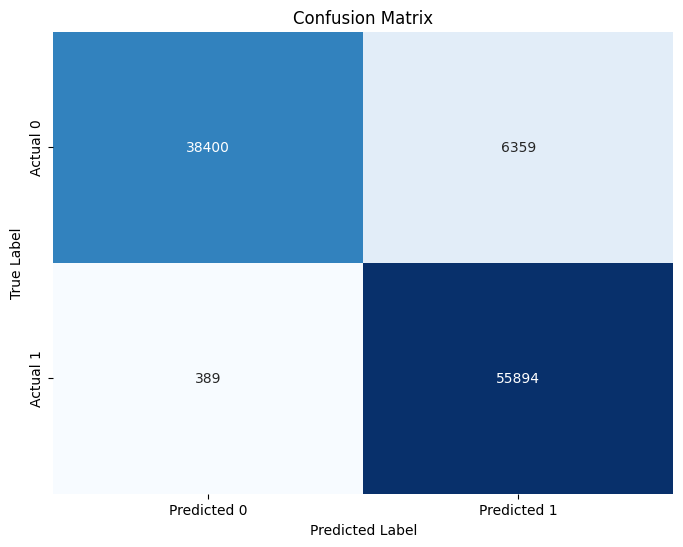

In [62]:
y_pred = xgb_classifier.predict(X_test)

print_evaluation_metrics(y_test, y_pred)

In [ ]:



with open("random_forest_model.pkl", 'wb') as model_file:
    pickle.dump(random_forest_classifier, model_file)
with open("xgb_model.pkl", 'wb') as model_file:
    pickle.dump(xgb_classifier, model_file)
with open("decision_model.pkl", 'wb') as model_file:
    pickle.dump(decision_tree_classifier, model_file)
with open("logistic_model.pkl", 'wb') as model_file:
    pickle.dump(logistic_classifier, model_file)

# Deployment

In [16]:
class CustomerChurnClassifier:
    
    def __init__(self, model_path, encoder_path):
        
        with open(model_path, 'rb') as file:
            self.model = pickle.load(file)
            
        with open(encoder_path, 'rb') as file:
            self.encoder = pickle.load(file)
    
    def predict(self, age: int, tenure: int, usage_frequency: int, support_calls: int, payment_delay: int, total_spend: float, last_interaction: int, gender: str, subscription_type: str, contract_length: str):
        
        
        expected_data_types = [int, int, int, int, int, float, int, str, str, str]
        input_arguments = [age, tenure, usage_frequency, support_calls, payment_delay, total_spend, last_interaction, gender, subscription_type, contract_length]
        input_arguments_names = ['age', 'tenure', 'usage_frequency', 'support_calls', 'payment_delay', 'total_spend', 'last_interaction', 'gender', 'subscription_type', 'contract_length']

        for i in range(len(input_arguments)):
            current_arg_type = type(input_arguments[i])

            if current_arg_type != expected_data_types[i]:
                raise TypeError(f"Error: Given {input_arguments_names[i]} ({current_arg_type.__name__}) is not of the expected type ({expected_data_types[i].__name__}).")
                
                
        
        valid_genders = ['Female', 'Male']
        valid_subscription_types = ['Standard', 'Basic', 'Premium']
        valid_contract_lengths = ['Annual', 'Monthly', 'Quarterly']

        if gender not in valid_genders:
            raise ValueError(f"Error: Invalid gender value '{gender}'. Expected one of {valid_genders}.")

        if subscription_type not in valid_subscription_types:
            raise ValueError(f"Error: Invalid subscription_type value '{subscription_type}'. Expected one of {valid_subscription_types}.")

        if contract_length not in valid_contract_lengths:
            raise ValueError(f"Error: Invalid contract_length value '{contract_length}'. Expected one of {valid_contract_lengths}.")
            
            
        
        
        ohe_data = list(self.encoder.transform([[gender, subscription_type, contract_length]])[0])
        
        to_predict_array = [age, tenure, usage_frequency, support_calls, payment_delay, total_spend, last_interaction] + ohe_data
        to_predict_array = np.array(to_predict_array).reshape((1, -1))
                
        prediction = self.model.predict(to_predict_array)[0]
        
        if prediction > 0.5:
            return 'Will Churn'
        else:
            return "Won't Churn"

c:\Users\91827\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Users\91827\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\91827\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Users\91827\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


'Will Churn'

In [17]:
customer_churn = CustomerChurnClassifier(
    model_path = 'xgb_model.pkl', 
    encoder_path = 'encoder.pkl'
)

# customer_churn = CustomerChurnClassifier(
#     model_path = 'decision_model.pkl', 
#     encoder_path = 'encoder.pkl')


In [ ]:

customer_churn = CustomerChurnClassifier(
    model_path = 'logistic_model.pkl', 
    encoder_path = 'encoder.pkl'
)
customer_churn = CustomerChurnClassifier(
    model_path = 'random_forest_model.pkl', 
    encoder_path = 'encoder.pkl'
)


In [18]:
customer_churn.predict(
    age = 22, 
    tenure = 28, 
    usage_frequency = 28, 
    support_calls = 10, 
    payment_delay = 13, 
    total_spend = 584.0, 
    last_interaction = 20, 
    gender = 'Female', 
    subscription_type = 'Standard', 
    contract_length = 'Monthly'
)


c:\Users\91827\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


'Will Churn'

In [19]:
customer_churn.predict(
    age = 11, 
    tenure = 12, 
    usage_frequency = 3, 
    support_calls = 7, 
    payment_delay = 15, 
    total_spend = 525.8, 
    last_interaction = 52, 
    gender = 'Male', 
    subscription_type = 'Basic', 
    contract_length = 'Annual'
)

c:\Users\91827\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


'Will Churn'